In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import tensorflow as tf
import tensorflow.keras.layers as L
# import cv2
import numpy as np
# from skimage import io

In [3]:
file = open("C:/Users/Sergey/Desktop/Diplom/Preprocessing/array2encoder", 'rb')
train_data = np.load(file)

In [4]:
file.close

<function BufferedReader.close>

In [8]:
IMG_SHAPE = train_data.shape[1:]
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    # encoder
    encoder = tf.keras.models.Sequential() # инициализация модели
    encoder.add(L.InputLayer(img_shape)) # добавление входного слоя, размер равен размеру изображения
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(14*14*256))
    decoder.add(L.Reshape((14, 14, 256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder


encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [19]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')
autoencoder.fit(x=train_data, y=train_data, epochs=15, verbose=1)

Epoch 1/15
395/395 [==============================] - 619s 2s/step - loss: 0.0076
Epoch 2/15
395/395 [==============================] - 607s 2s/step - loss: 0.0067
Epoch 3/15
395/395 [==============================] - 613s 2s/step - loss: 0.0066
Epoch 4/15
395/395 [==============================] - 630s 2s/step - loss: 0.0065
Epoch 5/15
395/395 [==============================] - 629s 2s/step - loss: 0.0064
Epoch 6/15
395/395 [==============================] - 638s 2s/step - loss: 0.0062
Epoch 7/15
395/395 [==============================] - 639s 2s/step - loss: 0.0061
Epoch 8/15
395/395 [==============================] - 710s 2s/step - loss: 0.0059
Epoch 9/15
395/395 [==============================] - 685s 2s/step - loss: 0.0058
Epoch 10/15
395/395 [==============================] - 650s 2s/step - loss: 0.0057
Epoch 11/15
395/395 [==============================] - 652s 2s/step - loss: 0.0056
Epoch 12/15
395/395 [==============================] - 655s 2s/step - loss: 0.0054
Epoch 13/15
3

In [8]:
images = train_data
codes = encoder.predict(images)
print(codes.shape) 
assert len(codes) == len(images)

395/395 [==============================] - 108s 270ms/step
(12630, 32)


In [20]:
    # open a binary file in write mode
    file = open("C:/Users/Sergey/Desktop/Diplom/Preprocessing/codes", "wb")
    np.save(file, codes)
    file.close


<function BufferedWriter.close>

In [153]:
autoencoder.summary()
autoencoder.layers[1].summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 32)                1994080   
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       2043971   
                                                                 
Total params: 4,038,051
Trainable params: 4,038,051
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D 

In [9]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="cosine")
nei_clf.fit(codes)

NearestNeighbors(metric='cosine')

In [9]:
train_data[50].shape

(224, 224, 3)

In [10]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"
    code = encoder.predict(image[None])    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    return distances,images[idx]
def show_similar(image):
    distances,neighbors = get_similar(image,n_neighbors=3)
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

1/1 [==============================] - 0s 132ms/step


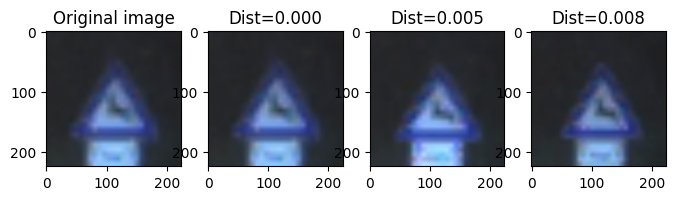

In [11]:
show_similar(train_data[3055])

In [72]:
autoencoder.save('Enc_CNN_encoder_2.h5')

In [24]:
file = open("arr", 'rb')
test_data = np.load(file)


1/1 [==============================] - 0s 31ms/step


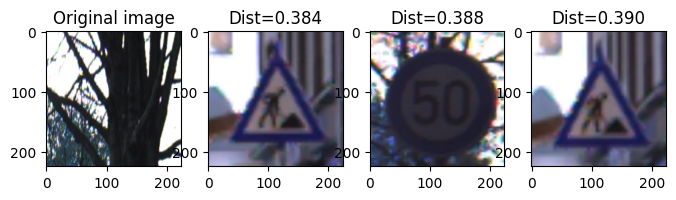

In [25]:
show_similar(test_data)


3


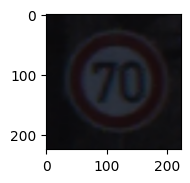

In [54]:
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    plt.imshow(test_data)
    print(test_data.ndim)

In [5]:
from keras.models import save_model, load_model

autoencoder = load_model('Enc_CNN')
# autoencoder.fit(x=train_data, y=train_data, epochs=10, verbose=1)

In [6]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 32)                1994080   
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       2043971   
                                                                 
Total params: 4,038,051
Trainable params: 4,038,051
Non-trainable params: 0
_________________________________________________________________


In [7]:
encoder = autoencoder.layers[1]